## Resources
-- Medium: [What is a Transformer](https://medium.com/inside-machine-learning/what-is-a-transformer-d07dd1fbec04)

-- YouTube: [Transformer Neural Networks - EXPLAINED! (Attention is all you need) ](https://www.youtube.com/watch?v=TQQlZhbC5ps)

-- The MIT NLP series are also very good.

## Theory

## Intro

Different sequence data architectures:
1. Vector-sequence models: e.g., inputs vectors representing pixels of an image and outputs a sequence of words describing the image (image captioning).

2. Sequence-Vector models: e.g., movie review in text format to ouput a score of how good or bad the movie is (sentiment analysis).

3. Sequence-sequence: e.g. language translation.

Sequence-to-Sequence (or Seq2Seq) is a neural net that transforms a given sequence of elements, such as the sequence of words in a sentence, into another sequence. (Well, this might not surprise you considering the name.)

Seq2Seq models are particularly good at translation, where the sequence of words from one language is transformed into a sequence of different words in another language.

A popular choice for this type of model is Long-Short-Term-Memory (LSTM)-based models.

Seq2Seq models consist of an Encoder and a Decoder. The Encoder takes the input sequence and maps it into a higher dimensional space (n-dimensional vector). That abstract vector is fed into the Decoder which turns it into an output sequence. The output sequence can be in another language, symbols, a copy of the input, etc.

The encoder is trained to transform data into a high dimensional representation which the decoder learns to transfrom to a sequence.

A very basic choice for the Encoder and the Decoder of the Seq2Seq model is a single LSTM for each of them.

In LSTMs, there are gates at each model to decide what part of the sequence is important and what are not. In general, this is called attention of a network. Transformers have this. It's like when you are reading, your mind doesn't remember all the words, it picks important words that will help you with context by the time you finish reading the sentence.

Let's say we have two people people who are translating English to French. The first person translates English to a third language (some imaginary language) and the second person translates from the imaginary language to French. Imagine that instead of only writing down the translation of the sentence in the imaginary language, the Encoder also writes down keywords that are important to the semantics of the sentence, and gives them to the Decoder in addition to the regular translation. Those new keywords make the translation much easier for the Decoder because it knows what parts of the sentence are important and which key terms give the sentence context. The decoder will take as inputs the encoded sentence and weights of each word (their importance).

So you need both the translation and a information on what words are important and should be included in the translation.

## Transformers
Transformers use the seq2seq attention mechanism but they actually don't apply neural networks. RNN were, until introduction of transformers, the best ways to capture timely dependencies in sequencies. The researchers on transformers (e.g, those working on BERT) proved that with only attention mechanisms and without RNN, we can actually improve translation tasks.

The reasons for wanting a different architecture than LSTMs are i) LSTMs are slow to train, and ii) LSTMs don't parallelize.  The execution of the next cell in an LSTM network depends on the previous one. The next won't execute before the previous one.

Transformers allow parallelization of sequencial data. Transformers take in all the words in a sequence simulteneously and generate imbeddings in one go.

The encoding and decoding blocks are primarily comprised of multi-head attention layers and feed forward layers.


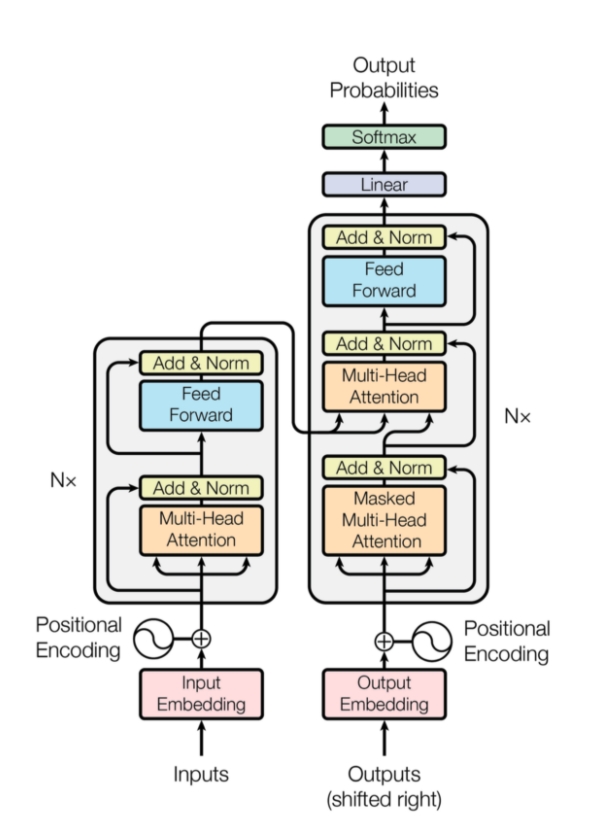


After inputs are transformed into embeddings (so they are intepretable by computer) and positional encoding is done, attention vectors are generated in the encoding block (see the rectangle). A feedforward block transforms each of the attention vectors into a form that is digestable by the next decorder or encoder block. The attention vectors are as many as the length of the sequence, each as long as the length of the sequence. Vector embeddings can be longer, so the vectors entering the encoding block have different dimensions than these attention vectors. So the attention vectors need to be transformed a bit before passing them again through the attention block of either the encoder of the decoder.

The `Nx` means you can have as many encoder/decoder block as you appropriate.

### Positional encoders
These are parts of the transformers that encode position of the word in the sentence. Sometimes words can mean different things depending on where are they are in a sentence. So having a positional encoder makes sure that the ultimate embedding has the position of the word accounted for. So you have embedding of a word plus positional encoding to give an embedding that has context.

Positional encoders are important because we are not using RNN which take care of sequential encoding by design.

### Feed-forward layers
These take the attention vectors and converts them into a form that is digestable by the next bloct (either for further encoding or for decoding).

### Multi-headed attention block
What part of the input should we focus on? How relevant is a word in relation to other words in the sentence? The attention layer outputs attention vectors. For each word, the length of the attention vector is equal to number of words in the sequence. e.g., the attention vectors for "this sentence" are `[0.9, 0.3]` and `[0.29, 0.89]`. It's like a correlation matrix. For the first one, it's saying "this" has importance of 0.9 in relation to itself, and 0.3 in relation to "sentence". etc.


### Encoder-decoder multi-head attention block
This takes both attention vectors from the previous part of the decorder and output vectors from the encoder to learn word associations.

### Attention mechanism
#### Self attention blocks (or dot-product attention blocks)

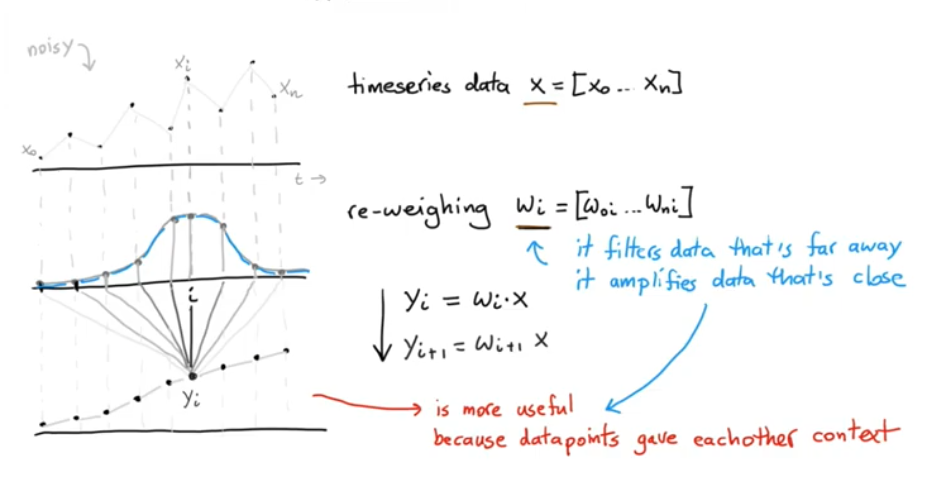

Let's say you have noisy data and you want to smooth it out. At $x_i$, you could make it such that the points near $x_i$ contribute more to $x_i$ than those further from it. So, you will have `n` weights, each for every data point that you multiply by $x_i$, to give updated vector of `x`, call it `y`.

The weights could come from some distribution for example. This reweighing amplifies the data that's close and reduces influence of data that's far out. The points near each other give each other more context. At $y_i$, the data points at $x_{i-1}$ and $x_{i+1}$, tell us more about what $x_i$ could be, than those too far out. They give $x_i$ more context.

That is for time series. For text though, proximity itself if not enough. This is because context in text doesn't necessarily come from proximity, but the words themselves. Word $x_i$ may not have much in common with word $x_{i-1}$, but maybe with word $x_{i+4}$.

The weight $w_{ij}$ where $i=j$ will be higher than most. That is ok because we want the data point to contribute to itself more than other data points.

With words, we can go through vector embeddings to help us get to a way to reweigh.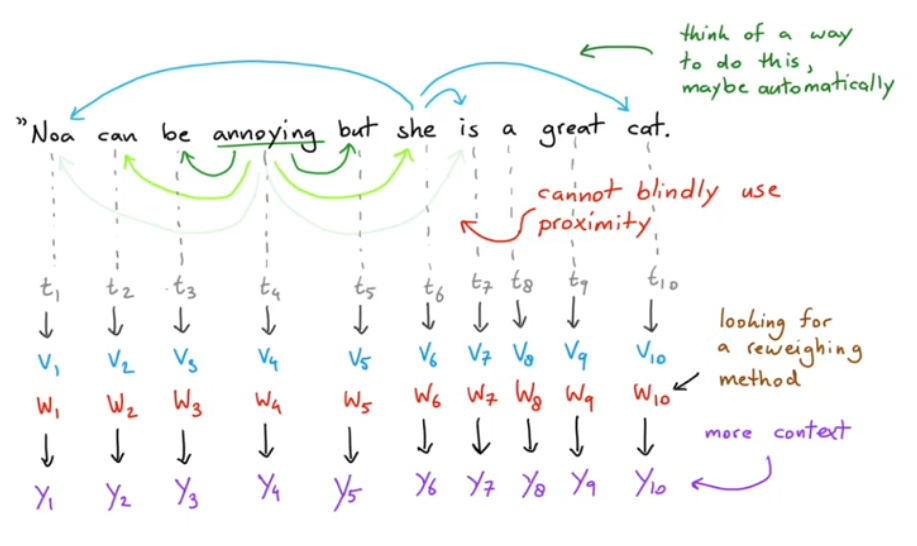

So to get $y_i$, we can work with dot product of the vector embeddings. Remember that dot product of two words tells you how similar they are.
 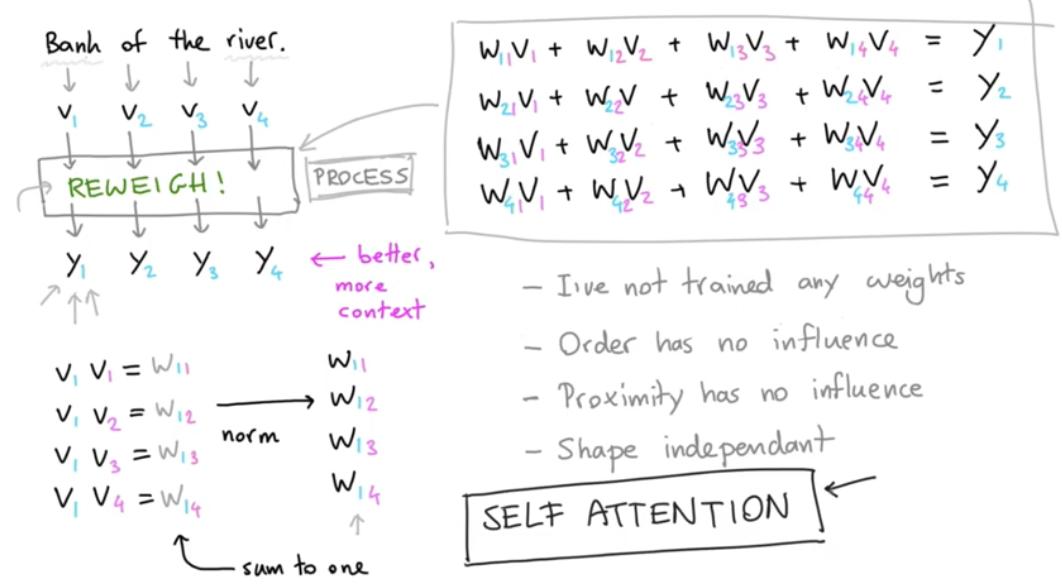

If we calculate the dot product of a vector ($v_i$) with every other vector, for each vector, we will have `n` weights. Each weight in is how similar $v_i$ is to every other vector. So, $w_{11}$ tells us how similar $v_1$ is to itself, $w_{12}$ tells us how similar $v_1$ is to $v_2$, $w_{13}$ tells us how similar $v_1$ is to $v_3$, etc. So if we want the overall effect of how all the vectors are similar to $v_1$, we multiply their corresponding weights with $v_1$ and add the results up. That gives you $y_1$, the self-attention of $x_i$. Also weights need to be normalized so results to blow up and so that they are comparable.

So far, the weights are deterministic. It makes sense to think that we can actually improve on this if we train the weights!

Let $i = 3$. Then the dot product of $v_i$ and rest of vectors would look like this. Note that we're involving all the vectors in the dot product. 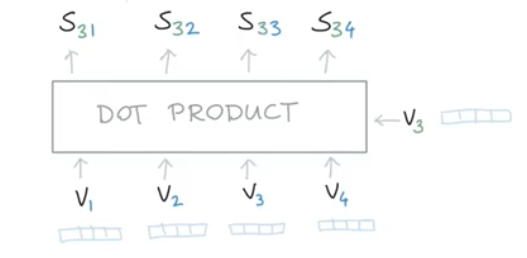

Where $S_{3i}$ is unscaled weight. If we normalize, we have:

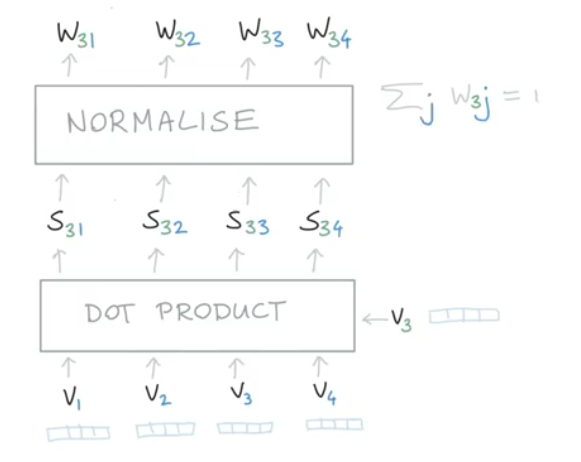

One way to normalize these weights is with softmax.

And then we multiply each weight with $v_3$ to get our $y_3$. This looks like this: (Note that we're still getting an array and we're also involving all the initial vectors in the process again)

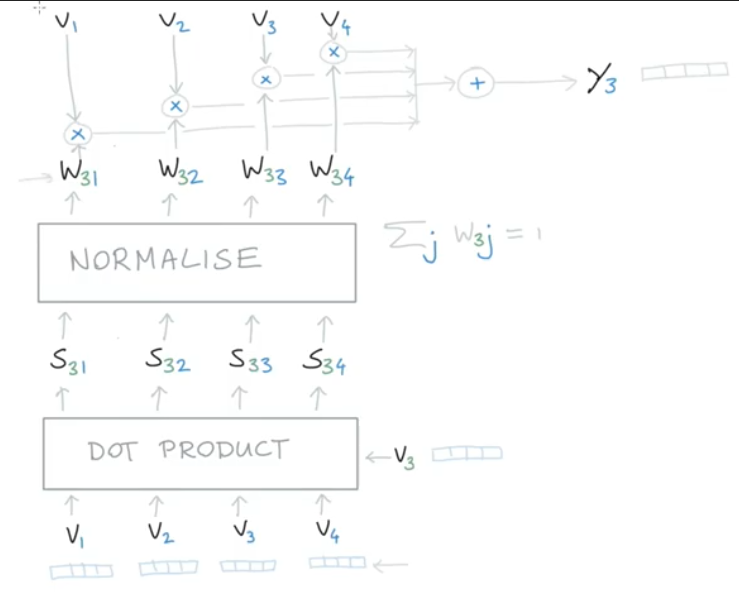



This can be repeated for all the other vectors.

#### Adding trained weights
In the illustration above, we reuse the vectors $v_i$ multiple times. And we did the calculations in an order.

At the dot product level, we can call $v_3$ a QUERY -- we are asking to get a context of $v_3$. We want this query on KEYS. The result of the query are values. Now, instead of doing everything in order and only working with one set of weights, we can do the operations at each stage in one go and have trained weights at each stage. There is no reason in doing things in order if we're learning the weights 'separately'. And we want to learn 'separately' so we can distribute the computation. We are doing things "separately", and distributing how we're learning the weights so it's along those "separate" paths help fine tune the weights. If, mathematically, we don't need weights for a given path, this will take care of itself.

We can learn three sets of weights separately, and then reconvene later to see how good those weights are (optimization). So as a system, we're learning the weights together, but we can do this in multiple paths that finally connect.

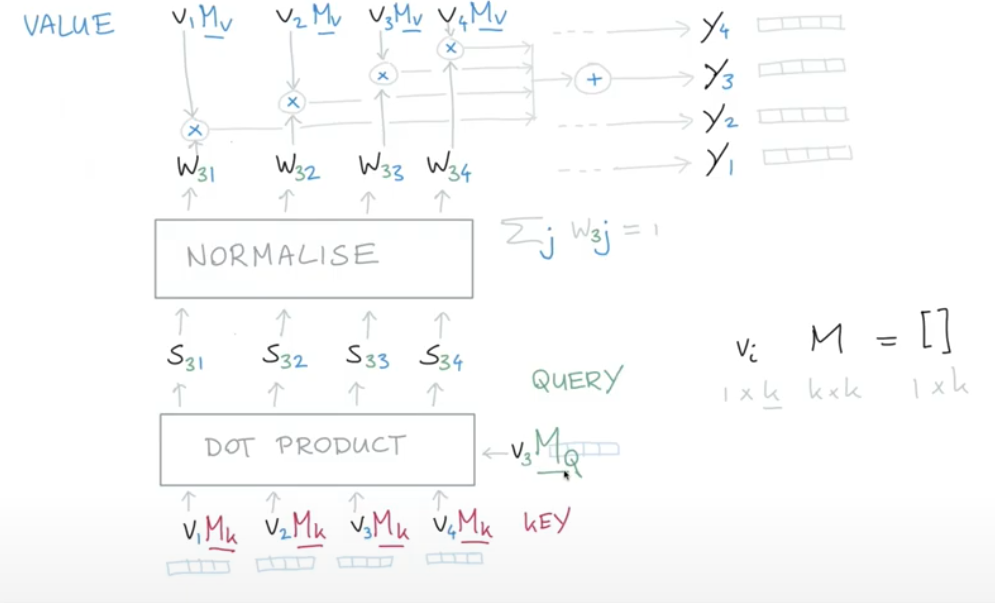

Doing it this way lets us use neural networks! With linear activations, a neural network is just a matrix of weights multiplied by input vector. We can input a matrix of vectors (where row i is the vector $v_i$ of the ith word), send the matrix down three modules of neural networks, combine the results such that you have self-attention weighted vectors as a result.

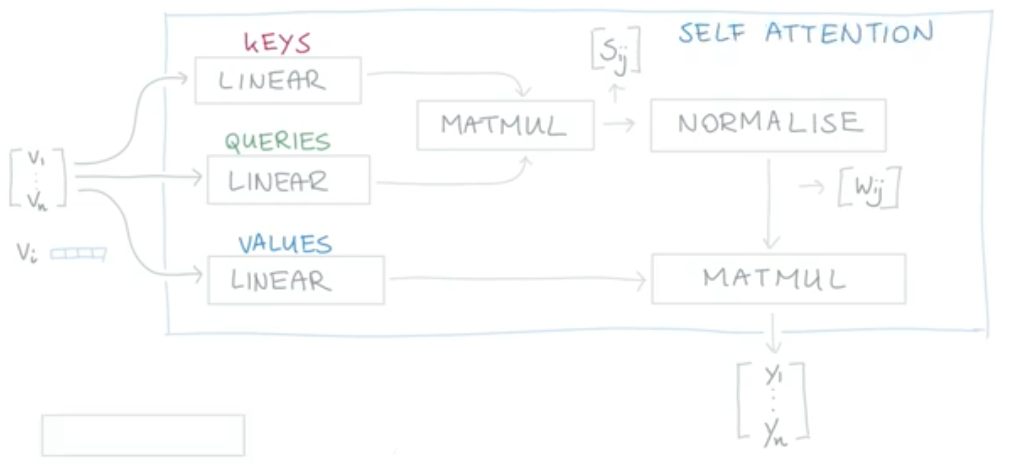

These self-attention blocks can be clicked together to reinforce learning.

#### Multi-head attention blocks
We said earlier that weight $w_{ij}$ where $i=j$ will be higher than most. In terms of numeric data, it's ok because we would want $x_i$ to contribute enough to what its smoothed out version is. With words though, it is useful but we don't want it to always be like this. This is because we're interested more in how words relate to one another, not to themselves. Unlike denoising with numbers, we want there to be some relationship between the original data and the denoised data. With words, we're not very interested in one word $x_i$ relates to itself.

Creating multiple attention vectors takes care of this. Since we're training the weights and we have random initialization, it is possible to sometimes have low weights even for $w{i,j}$ were $i=j$. So, if we want to make sure the word itself is not dominating its self attention, we do this multiple times. We have multiple heads of attention modules resulting in what's called multi-head attention block.

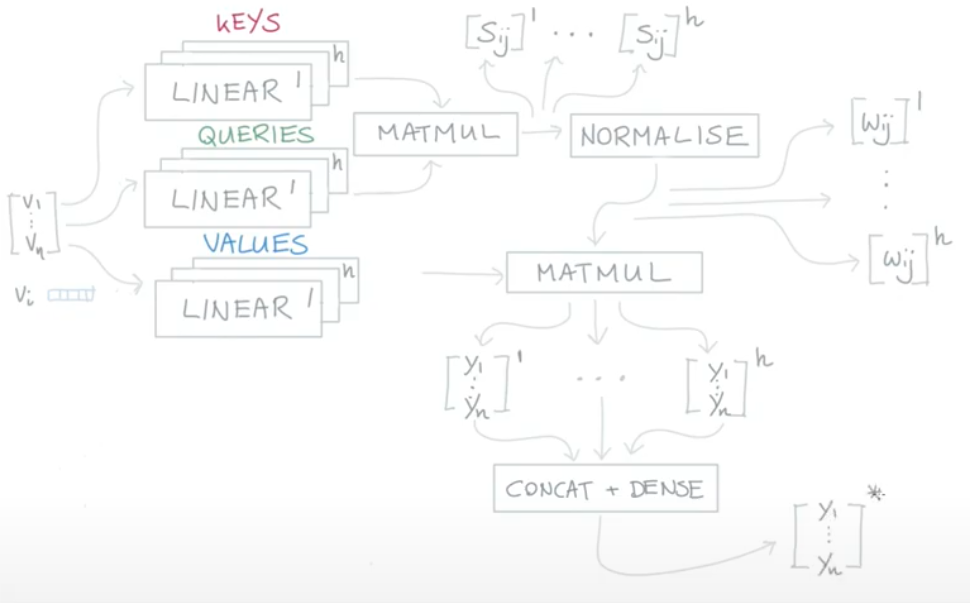

At the end, we concatenate the `h` vectors and have additional linear layers that help us further customize the results.

### Everything Together


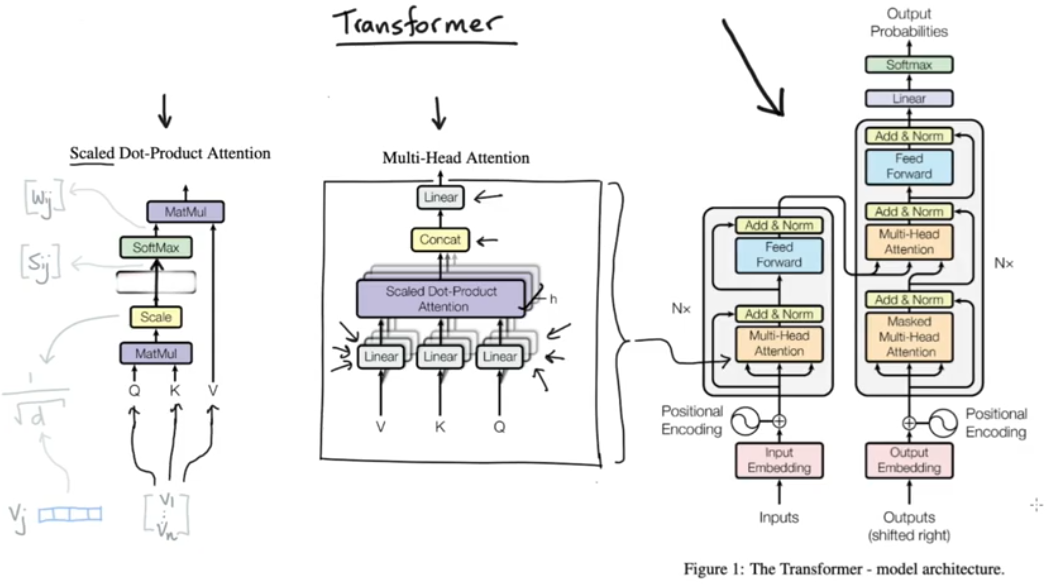

In addition to the matrix multiplication on vectors Q and K, scaling is done $(1/\sqrt{d})$ where d is the length of the vectors. This is for numeric stability during optimization.

Notice that there is `add & norm` steps in the blocks. This combines results from the neural network blocks with original inputs to those blocks. This is to make sure we're not running into vanishin gradient problem. And, no, this doesn't mean the ultimate results will be equivalent to just doing all the calculation to the end and combining with the original input at the very beginning of the larger block. It's not linear. We're combining results of a smaller block with the inputs of that block.

You can have many many of these blocks and it could lead to vanishing gradients. You need to avoid that.

Don't know how, but you can just take the encoder part and apply it to things like virtual assistants etc. Is it because it helps contextualize a conversation? Maybe I think.

`Nx` can be optimized too. Number of heads for each attention block can be tuned too.

You can also train the positional encoding. Or you could just find a function that has some good properties that you like.

For translation, the masked multi-head attention block inputs are not complete because we don't want the neural network to memorize the training data. We want it to learn from the first language we're translating from and what's been said/written so far in the second language. I can use all the knowledge in the first language when training, but not all in the second. It will overfit.

When you are training, that first part of the decoder is like your 'label' (or rather, it's part of the whole label). The multi-head attention block receiving both from the decoder and the encoder is where you are sort of comparing your vectors and understanding how they relate between the encoded and the corresponding output vectors. It's where the decoder finds which part of the encoder to focus on. It's the attention mechanism paying off -- it looks at the word its translating and what it's attention to help it decide translation and context.

After a word is translated, it goes back in through the back of the decoder so it can help decide the next word. So, when deciding the next word, the decoder looks at both the word translated so far and the encoding of the next word to be translated. It looks at the attention of the this next word to be translated and decides its context to help predict the word that follows the already translated word.


## Implementation

In [ ]:
!pip install datasets
!pip install pytorch-ignite
!pip install wldhx.yadisk-direct

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 7.6 MB/s eta 0:00:00


In [ ]:
import torch
import math
import json
import random

from tqdm import tqdm

from torch import Tensor
from torch import nn
from datasets import Dataset
from ignite.metrics import Rouge

from transformers import AutoTokenizer
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


#### Attn Mask Function
Borrowed from the Transfomer code by Huggingface.

In [ ]:
def generate_square_subsequent_mask(sz):
  mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
  mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
  return mask

#### Positional Embedding
Borrowed from the `spotpython` library. See [`spotpython.light.transformer.positionalEncoding`](https://github.com/sequential-parameter-optimization/spotPython/blob/main/src/spotpython/light/transformer/positionalEncoding.py).

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, max_len: int = 5000) -> None:
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Add positional encoding to the input tensor.

        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``

        Returns:
            Tensor, shape ``[seq_len, batch_size, embedding_dim]``

        Raises:
            IndexError: if the positional encoding cannot be added to the input tensor
        """
        return x + self.pe[:x.size(0)]

#### Encoder Layer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, embed_dim, output_dim, num_heads):
        super().__init__()
        self.mh_self_attn = nn.MultiheadAttention(
            embed_dim=embed_dim, num_heads=num_heads
        )
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.linear1 = nn.Linear(embed_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(output_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(self, x, src_key_padding_mask, dropout=True):
        # Multihead self-attention
        self_attn_output, _ = self.mh_self_attn(
            query=x, key=x, value=x,
            key_padding_mask=src_key_padding_mask
        )
        # Add multihead output to input and normalize
        self_attn_output = self_attn_output + x
        self_attn_output = self.norm1(self_attn_output)

        # Feedforward
        ff_output = self.relu(self.linear1(self_attn_output))
        ff_output = self.norm2(ff_output)
        ff_output = self.dropout(ff_output)
        ff_output = self.linear2(ff_output)

        # Add attention output to feed forward output and normalize
        output = ff_output + self_attn_output
        output = self.norm3(output)

        return output

#### Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, embed_dim, output_dim, num_heads):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.mmh_self_attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mh_self_attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.linear1 = nn.Linear(embed_dim, output_dim)
        self.linear2 = nn.Linear(output_dim, embed_dim)
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(output_dim)
        self.norm3 = nn.LayerNorm(embed_dim)

    def forward(
        self, x, encoder_output, trg_key_padding_mask,
        src_key_padding_mask, trg_attn_mask, dropout=True
        ):
        # Masked multihead self-attention
        self_attn_output, _ = self.mmh_self_attn(
            query=x, key=x, value=x,
            is_causal=False, attn_mask=trg_attn_mask,
            key_padding_mask=trg_key_padding_mask
        )

        # Add self-attention output to input and normalize
        self_attn_output = self_attn_output + x
        self_attn_output = self.norm1(self_attn_output)

        # Multihead encoder-decoder attention
        attn_output, _ = self.mh_self_attn(
            query=self_attn_output, key=encoder_output, value=encoder_output,
            key_padding_mask=src_key_padding_mask
        )

        # Add encoder-decoder attn output to decoder self-attn ouput and normalize
        attn_output = attn_output + self_attn_output
        attn_output = self.norm1(attn_output)

        # Feedforward
        ff_output = self.relu(self.linear1(attn_output))
        ff_output = self.norm2(ff_output)
        ff_output = self.dropout(ff_output)
        ff_output = self.linear2(ff_output)

        # Add x to output and normalize
        output = ff_output + attn_output
        output = self.norm3(output)

        return output

#### Full Transformer Model

In [ ]:
class Transformer(nn.Module):
    def __init__(
        self,
        embed_dim,
        output_dim,
        encoder_heads,
        decoder_heads,
        encoder_layers,
        decoder_layers,
    ):
        super().__init__()
        self.src_embedding = nn.Embedding(
            embedding_dim=embed_dim,
            num_embeddings=german_tokenizer.vocab_size + 1, padding_idx=0 # add [EOS] to vocab size
        )
        self.trg_embedding = nn.Embedding(
            embedding_dim=embed_dim,
            num_embeddings=english_tokenizer.vocab_size + 2, padding_idx=0 # add [BOS] and [EOS] to vocab size
        )
        self.pos_encoder = PositionalEncoding(d_model=embed_dim)

        self.encoder = nn.ModuleList(
            [
                EncoderLayer(embed_dim, output_dim, encoder_heads)
                for _ in range(encoder_layers)
            ]
        )
        self.decoder = nn.ModuleList(
            [
                DecoderLayer(embed_dim, output_dim, decoder_heads)
                for _ in range(decoder_layers)
            ]
        )
        self.linear = nn.Linear(embed_dim, english_tokenizer.vocab_size + 2)
        # self.softmax = nn.Softmax(dim=-1)

    def forward(
        self, src_x, trg_x, src_key_padding_mask,
        trg_key_padding_mask, trg_attn_mask=None,
        decoder_only=False, return_encoder_output=False
        ):

        trg_embed = self.trg_embedding(trg_x)
        trg = self.pos_encoder(trg_embed)

        # pos_encoder already does the summation
        # src = src_embed + src_pos
        # trg = trg_embed + trg_pos

        if not decoder_only:
          src_embed = self.src_embedding(src_x)
          src = self.pos_encoder(src_embed)
          for layer in self.encoder:
              src = layer(src, src_key_padding_mask)
        else:
          src = src_x

        for layer in self.decoder:
            trg = layer(trg, src, trg_key_padding_mask, src_key_padding_mask, trg_attn_mask)

        output = self.linear(trg)

        if return_encoder_output:
          output = output, src

        return output

### Data

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load Data

In [ ]:
!curl -L $(yadisk-direct https://disk.yandex.com/d/Q6Bm9NoG1VWcgA) -o valid_data.jsonl
!curl -L $(yadisk-direct https://disk.yandex.com/d/2V3YpeogygoBTA) -o train_data.jsonl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 1825k  100 1825k    0     0   542k      0  0:00:03  0:00:03 --:--:-- 1153k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 7299k  100 7299k    0     0  2056k      0  0:00:03  0:00:03 --:--:-- 4573k


### Preprocess Data

In [ ]:
german_tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased", clean_up_tokenization_spaces=True) # casing matters in German
english_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased", clean_up_tokenization_spaces=True)

english_tokenizer.add_tokens(['[BOS]', '[EOS]'], special_tokens=True)
german_tokenizer.add_tokens(['[EOS]'], special_tokens=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/456 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/240k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

1

In [ ]:
def german_tokenize(text):
 return german_tokenizer(
     text["german"],
     add_special_tokens=False,
     max_length=100, # attn masking and padding masking is easier when fixed
     padding='max_length',
     truncation=True,
     return_tensors='pt'
  )

def english_tokenize(text):
  return english_tokenizer(
      text["english"],
      add_special_tokens=False,
      max_length=100, # attn masking and padding masking is easier when fixed
      padding='max_length',
      truncation=True,
      return_tensors='pt'
)

In [ ]:
def read_corpus(filename):

    data = {"german": [], "english": []}
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file.readlines():
            json_line = json.loads(line)
            data["german"].append(json_line['de'] + ' [EOS]')
            data["english"].append('[BOS] ' + json_line['en'] + ' [EOS]') # shift target right
    return data

train_data = Dataset.from_dict(read_corpus('train_data.jsonl'))
valid_data = Dataset.from_dict(read_corpus('valid_data.jsonl'))

src_train_data = train_data.map(german_tokenize, batched=True)
trg_train_data = train_data.map(english_tokenize, batched=True)
src_valid_data = valid_data.map(german_tokenize, batched=True)
trg_valid_data = valid_data.map(english_tokenize, batched=True)

del train_data
del valid_data

Map:   0%|          | 0/87906 [00:00<?, ? examples/s]

Map:   0%|          | 0/87906 [00:00<?, ? examples/s]

Map:   0%|          | 0/21976 [00:00<?, ? examples/s]

Map:   0%|          | 0/21976 [00:00<?, ? examples/s]

In [ ]:
src_train_data = src_train_data.remove_columns(['german', 'english', 'token_type_ids'])
src_valid_data = src_valid_data.remove_columns(['german', 'english', 'token_type_ids'])
trg_train_data = trg_train_data.remove_columns(['german', 'english', 'token_type_ids'])
trg_valid_data = trg_valid_data.remove_columns(['german', 'english', 'token_type_ids'])

In [ ]:
src_train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
src_valid_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
trg_train_data.set_format(type="torch", columns=["input_ids", "attention_mask"])
trg_valid_data.set_format(type="torch", columns=["input_ids", "attention_mask"])

In [ ]:
src_train_loader = DataLoader(src_train_data, batch_size=128) # , generator=torch.Generator(device=device))
trg_train_loader = DataLoader(trg_train_data, batch_size=128) # , generator=torch.Generator(device=device))
src_valid_loader = DataLoader(src_valid_data, batch_size=1) # , generator=torch.Generator(device=device))
trg_valid_loader = DataLoader(trg_valid_data, batch_size=1) # , generator=torch.Generator(device=device))

In [ ]:
EMBED_DIM = 200
OUTPUT_DIM = 200
ENCODER_HEADS = 4
DECODER_HEADS = 4
ENCODER_LAYERS = 1
DECODER_LAYERS = 1

In [ ]:
model = Transformer(
    EMBED_DIM,
    OUTPUT_DIM,
    ENCODER_HEADS,
    DECODER_HEADS,
    ENCODER_LAYERS,
    DECODER_LAYERS
)

model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

In [ ]:
epochs = 81
N = len(src_train_loader) # number of batches
losses = []
for epoch in range(71, epochs):
    model.train()
    epoch_loss = 0
    for src_batch, trg_batch in zip(src_train_loader, trg_train_loader):
        src_x = src_batch['input_ids'].T.to(device)
        trg_x = trg_batch['input_ids'].T.to(device)
        labels = trg_batch['input_ids'][:,1:] # remove [BOS]

        labels = torch.cat((labels, torch.zeros((labels.shape[0], 1))), dim=1) # add a row of 0's to correct padding
        labels = labels.type(torch.LongTensor).to(device)

        trg_attn_mask = generate_square_subsequent_mask(trg_x.shape[0]).to(device)
        src_key_padding_mask = (src_batch['attention_mask'] == 0).to(device)
        trg_key_padding_mask = (trg_batch['attention_mask'] == 0).to(device)

        optimizer.zero_grad()

        output = model(src_x, trg_x, src_key_padding_mask, trg_key_padding_mask, trg_attn_mask)
        output = output.permute(1, 2, 0)

        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    losses.append(epoch_loss)
    print(f"Epoch: {epoch + 1}, Loss: {epoch_loss/N}")

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 72, Loss: 0.013093243819407935
Epoch: 73, Loss: 0.012924733132481835
Epoch: 74, Loss: 0.01269235717216737
Epoch: 75, Loss: 0.012788499793609851
Epoch: 76, Loss: 0.012481475193351724
Epoch: 77, Loss: 0.012590345104389012
Epoch: 78, Loss: 0.012423803915948847
Epoch: 79, Loss: 0.012145612359703064
Epoch: 80, Loss: 0.012221847175521534
Epoch: 81, Loss: 0.012483119674493306


In [ ]:
print(list(range(71, 81)))

[71, 72, 73, 74, 75, 76, 77, 78, 79, 80]


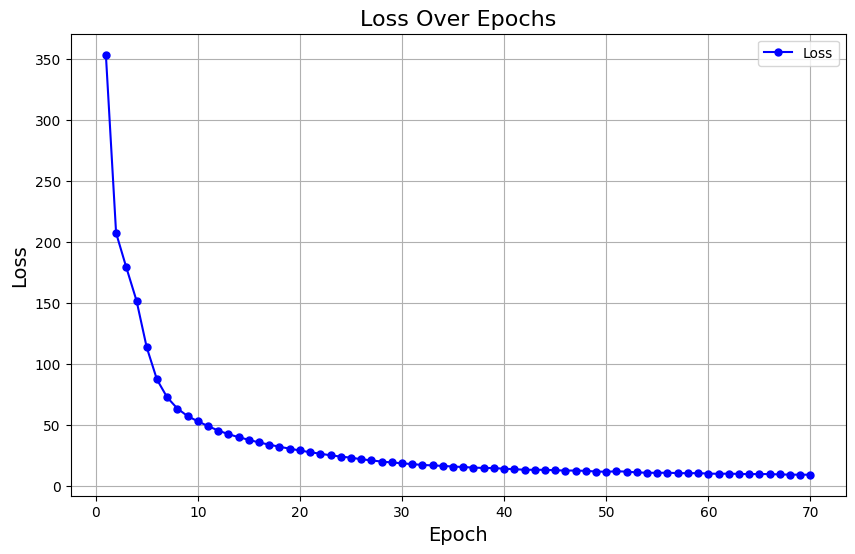

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, epochs + 1)), losses, marker='o', color='b', linestyle='-', markersize=5, label='Loss')

plt.title('Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.grid(True)
plt.legend()

plt.show()

In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
EMBED_DIM = 200
OUTPUT_DIM = 200
ENCODER_HEADS = 4
DECODER_HEADS = 4
ENCODER_LAYERS = 1
DECODER_LAYERS = 1

model = Transformer(
    EMBED_DIM,
    OUTPUT_DIM,
    ENCODER_HEADS,
    DECODER_HEADS,
    ENCODER_LAYERS,
    DECODER_LAYERS
)
model.load_state_dict(torch.load('model.pth'))
# model.load_state_dict(torch.load('model.pth', map_location=torch.device(device)))
model = model.to(device)

In [ ]:
EOS = 30523
trans_samples = []
rouge = Rouge(variants=["L", 3, 2], multiref="best")

for src_batch, trg_batch in tqdm(zip(src_valid_loader, trg_valid_loader), total=len(src_valid_loader)):
    src_x = src_batch['input_ids'].T.to(device)
    src_key_padding_mask = (src_batch['attention_mask'] == 0).to(device)
    trg_x = trg_batch['input_ids'][:,0].unsqueeze(0).to(device)

    model.eval()
    output, src_x = model(
        src_x, trg_x, src_key_padding_mask,
        trg_key_padding_mask=None, return_encoder_output=True
    )
    output_ids = output.argmax(-1)
    batch_size = trg_batch['attention_mask'].shape[1]
    for idx in range(batch_size):
      trg_x = torch.cat((trg_x, output_ids[idx,:].unsqueeze(0)))

      output = model(
          src_x, trg_x, src_key_padding_mask,
          trg_key_padding_mask=None, decoder_only=True
      )
      output_ids = output.argmax(-1)

      if output_ids.T.squeeze(0)[-1].item() == EOS:
        candidate = (trg_x.T.squeeze(0)[1:]).tolist()
        break

    reference = trg_batch['input_ids'][:,1:].squeeze()
    padding_index = torch.where(reference == EOS)[0].item()
    reference = (reference[:padding_index]).tolist()

    reference = [[str(r) for r in reference]]
    candidate = [str(id) for id in candidate]

    rouge.update(([candidate], [reference]))

    number = random.randint(0, 64)
    if number == 4:
      trans_samples.append((candidate, reference))

rouge.compute()

100%|██████████| 21976/21976 [06:47<00:00, 53.93it/s]


{'Rouge-L-P': 0.7080252423423158,
 'Rouge-L-R': 0.6807859781661261,
 'Rouge-L-F': 0.6807859781661261,
 'Rouge-3-P': 0.3970865601891901,
 'Rouge-3-R': 0.38771847797973336,
 'Rouge-3-F': 0.38771847797973336,
 'Rouge-2-P': 0.5028224035123767,
 'Rouge-2-R': 0.48795272303498166,
 'Rouge-2-F': 0.48795272303498166}